# Generate AnnData - Breast cancer

In [1]:
import scanpy as sc
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

In [2]:
sc.set_figure_params(dpi=120)

## Read in the raw data, annotations and segmentation information

### Counts

In [3]:
count_df = pd.read_csv('data/CN21_BC24350_E2_unmodgtf_filtered_red_ut.tsv', sep='\t')
count_df.head()

x    y             ensG   bc_old       bc          ensGV.x  count  \
0  474  395  ENSG00000278996  474x395  474x395  ENSG00000278996      1   
1  474  397  ENSG00000159210  474x397  474x397  ENSG00000159210      1   
2  474  397  ENSG00000174165  474x397  474x397  ENSG00000174165      1   
3  474  397  ENSG00000182048  474x397  474x397  ENSG00000182048      1   
4  474  398  ENSG00000010256  474x398  474x398  ENSG00000010256      1   

              ensGV.y        gene  spot_px_y  spot_px_x  
0   ENSG00000278996.1  FP671120.2       3864       4797  
1   ENSG00000159210.9        SNF8       3879       4797  
2   ENSG00000174165.8     ZDHHC24       3879       4797  
3  ENSG00000182048.11       TRPC2       3879       4797  
4  ENSG00000010256.11      UQCRC1       3886       4792

In [4]:
len(set(count_df.gene))

22733

### Segmentation 

In [5]:
segment_df = pd.read_csv('data/segmentation/CellID_Spot_Position_CN21_E2_filtered_red_ut_BC_flipped.csv', sep=',')
segment_df['x'] = [int(x.split('x')[0]) for x in segment_df.bc]
segment_df['y'] = [int(x.split('x')[1]) for x in segment_df.bc]
segment_df.set_index('bc', inplace=True)
segment_df = segment_df[['x', 'y', 'cell_id']].rename(columns={'cell_id': 'segment_id'})
segment_df['segment_id'] = segment_df['segment_id'].astype(str)
segment_df.head()

x    y segment_id
bc                          
474x397  474  397      31151
474x398  474  398      31151
474x399  474  399      31151
474x400  474  400      31151
475x298  475  298      24213

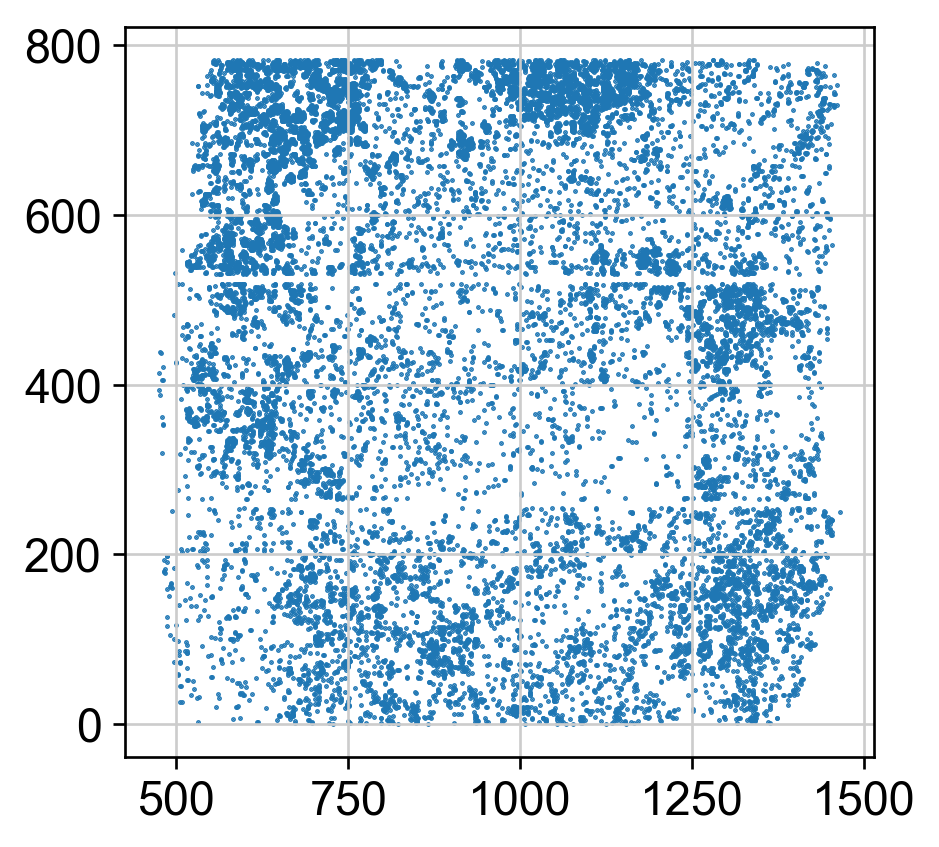

In [6]:
df = segment_df[segment_df.segment_id == '0'] # background
plt.scatter(df.x, df.y, s=0.2)

### Annotations

In [7]:
region_df = pd.read_csv('data/CN21_BC24350_E2_barcodes_under_tissue_annot.tsv', sep='\t', dtype={'point.ID': int, 
                                                                                                 'spot_y': int, 
                                                                                                 'spot_x': int, 
                                                                                                 'spot_px_y': int, 
                                                                                                 'spot_px_x': int})
region_df.index = ['%sx%s' % (x, y) for x,y in zip(region_df.spot_x, region_df.spot_y)]
region_df.head()

point.ID  spot_y  spot_x  spot_px_y  spot_px_x  \
529x782         1     782     529       6719       5250   
530x782         2     782     530       6719       5258   
531x782         3     782     531       6719       5267   
532x782         4     782     532       6719       5275   
533x782         5     782     533       6719       5284   

                                poly.ID   poly  
529x782  Fibrous tissue;Invasive cancer  479.0  
530x782  Fibrous tissue;Invasive cancer  479.0  
531x782  Fibrous tissue;Invasive cancer  479.0  
532x782  Fibrous tissue;Invasive cancer  479.0  
533x782  Fibrous tissue;Invasive cancer  479.0

In [8]:
all_df = pd.merge(region_df, count_df, left_on=('spot_x', 'spot_y'), right_on=('x', 'y'), how='left')
all_df = pd.merge(all_df, segment_df, left_on=('spot_x', 'spot_y'), right_on=('x', 'y'), how='left')

all_df.loc[all_df['count'].isnull(), 'count'] = 0.0

all_df.loc[all_df['ensG'].isnull(), 'ensG'] = 'ENSG00000159210' #random gene as placeholders
all_df['ensG'] = all_df['ensG'].astype('category')

all_df.loc[all_df['gene'].isnull(), 'gene'] = 'SNF8' #random gene as placeholders 
all_df['gene'] = all_df['gene'].astype('category')

all_df.loc[:, 'bc'] = ['%sx%s' % (a,b) for a,b in zip(all_df.loc[:, 'spot_x'], all_df.loc[:, 'spot_y'])]
all_df['bc'] = all_df['bc'].astype('category')

all_df.head()

point.ID  spot_y  spot_x  spot_px_y_x  spot_px_x_x  \
0         1     782     529         6719         5250   
1         1     782     529         6719         5250   
2         1     782     529         6719         5250   
3         1     782     529         6719         5250   
4         1     782     529         6719         5250   

                          poly.ID   poly    x_x    y_x             ensG  ...  \
0  Fibrous tissue;Invasive cancer  479.0  529.0  782.0  ENSG00000142534  ...   
1  Fibrous tissue;Invasive cancer  479.0  529.0  782.0  ENSG00000158417  ...   
2  Fibrous tissue;Invasive cancer  479.0  529.0  782.0  ENSG00000197766  ...   
3  Fibrous tissue;Invasive cancer  479.0  529.0  782.0  ENSG00000206573  ...   
4  Fibrous tissue;Invasive cancer  479.0  529.0  782.0  ENSG00000232888  ...   

        bc          ensGV.x count             ensGV.y         gene  \
0  529x782  ENSG00000142534   2.0   ENSG00000142534.7        RPS11   
1  529x782  ENSG00000158417   1.0  ENSG00000158417.11        EIF5B   
2  529x782  ENSG00000197766   1.0   ENSG00000197766.7          CFD   
3  529x782  ENSG00000206573   1.0   ENSG00000206573.8  THUMPD3-AS1   
4  529x782  ENSG00000232888   1.0   ENSG00000232888.4      RPS11P5   

  spot_px_y_y  spot_px_x_y    x_y    y_y  segment_id  
0      6719.0       5250.0  529.0  782.0       55270  
1      6719.0       5250.0  529.0  782.0       55270  
2      6719.0       5250.0  529.0  782.0       55270  
3      6719.0       5250.0  529.0  782.0       55270  
4      6719.0       5250.0  529.0  782.0       55270  

[5 rows x 21 columns]

In [9]:
(np.min(count_df.x.values), np.max(count_df.x.values)), (np.min(count_df.y.values), np.max(count_df.y.values))

((474, 1476), (1, 782))

In [10]:
(np.min(region_df.spot_x.values), np.max(region_df.spot_x.values)), (np.min(region_df.spot_y.values), np.max(region_df.spot_y.values))

((473, 1476), (0, 782))

In [11]:
len(region_df), len(count_df)

(742440, 697049)

## Scanpy AnnData

In [12]:
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

barcodes = CategoricalDtype(sorted(all_df.bc.unique()), ordered=True)
genes = CategoricalDtype(sorted(all_df.ensG.unique()), ordered=True)

row = all_df.bc.astype(barcodes).cat.codes
col = all_df.ensG.astype(genes).cat.codes
sparse_count_matrix = csr_matrix((all_df["count"], (row, col)), \
                                 shape=(barcodes.categories.size, 
                                        genes.categories.size))
sparse_count_matrix

<742440x23058 sparse matrix of type '<class 'numpy.float64'>'
	with 1261563 stored elements in Compressed Sparse Row format>

In [13]:
barcodes.categories.size, genes.categories.size

(742440, 23058)

In [14]:
# fraction of nonzeros
(sparse_count_matrix.nnz / np.prod(sparse_count_matrix.shape)) * 100.

0.007369295071298479

In [15]:
sparse_count_df = pd.SparseDataFrame(sparse_count_matrix, \
                                     index=barcodes.categories, \
                                     columns=genes.categories, \
                                     default_fill_value=0,
                                     dtype=int)
sparse_count_df.head()

ENSG00000000003  ENSG00000000419  ENSG00000000457  ENSG00000000460  \
1000x0                0.0              0.0              0.0              0.0   
1000x1                0.0              0.0              0.0              0.0   
1000x10               0.0              0.0              0.0              0.0   
1000x100              0.0              0.0              0.0              0.0   
1000x101              0.0              0.0              0.0              0.0   

          ENSG00000000938  ENSG00000000971  ENSG00000001036  ENSG00000001084  \
1000x0                0.0              0.0              0.0              0.0   
1000x1                0.0              0.0              0.0              0.0   
1000x10               0.0              0.0              0.0              0.0   
1000x100              0.0              0.0              0.0              0.0   
1000x101              0.0              0.0              0.0              0.0   

          ENSG00000001167  ENSG00000001460  ...  ENSG00000281731  \
1000x0                0.0              0.0  ...              0.0   
1000x1                0.0              0.0  ...              0.0   
1000x10               0.0              0.0  ...              0.0   
1000x100              0.0              0.0  ...              0.0   
1000x101              0.0              0.0  ...              0.0   

          ENSG00000281732  ENSG00000281741  ENSG00000281769  ENSG00000281823  \
1000x0                0.0              0.0              0.0              0.0   
1000x1                0.0              0.0              0.0              0.0   
1000x10               0.0              0.0              0.0              0.0   
1000x100              0.0              0.0              0.0              0.0   
1000x101              0.0              0.0              0.0              0.0   

          ENSG00000281825  ENSG00000281831  ENSG00000281883  ENSG00000281896  \
1000x0                0.0              0.0              0.0              0.0   
1000x1                0.0              0.0              0.0              0.0   
1000x10               0.0              0.0              0.0              0.0   
1000x100              0.0              0.0              0.0              0.0   
1000x101              0.0              0.0              0.0              0.0   

          ENSG00000281909  
1000x0                0.0  
1000x1                0.0  
1000x10               0.0  
1000x100              0.0  
1000x101              0.0  

[5 rows x 23058 columns]

## Import the sparse dataframe to Scanpy

In [16]:
adata = sc.AnnData(sparse_count_df.to_coo().tocsr())
adata.obs_names = sparse_count_df.index.values
adata.var_names = sparse_count_df.columns.values
adata

AnnData object with n_obs × n_vars = 742440 × 23058 

In [17]:
adata.obs.head()

Empty DataFrame
Columns: []
Index: [1000x0, 1000x1, 1000x10, 1000x100, 1000x101]

In [18]:
sum((adata.X.sum(0) == 0).A1)

0

## Add spatial coordinates, gene ids and region annotations

In [19]:
enstogene = count_df[['ensG', 'gene']].drop_duplicates()
enstogene.index = enstogene.ensG

# replace NA gene symbols with ensembl ids
nans = pd.isnull(enstogene.gene.values)
enstogene.gene[nans] = enstogene.ensG[nans]
enstogene.head()

ensG        gene
ensG                                        
ENSG00000278996  ENSG00000278996  FP671120.2
ENSG00000159210  ENSG00000159210        SNF8
ENSG00000174165  ENSG00000174165     ZDHHC24
ENSG00000182048  ENSG00000182048       TRPC2
ENSG00000010256  ENSG00000010256      UQCRC1

In [20]:
# Use negative coordinates as a workaround for the annoying difference in the interpretation of 0,0 point between spatial people and cartesian coords.
adata.obsm['X_spatial'] = np.vstack(([int(x.split('x')[0]) for x in adata.obs_names.values],
                                     [int(x.split('x')[1]) for x in adata.obs_names.values])).T
adata.var['gene_symbols'] = enstogene.gene
adata.var['gene_ids'] = enstogene.ensG
adata.obs['region'] = region_df['poly.ID']
adata.obs['segment'] = segment_df['segment_id']
adata.obs['segment'].fillna('0', inplace=True)

# replace gene symbols with ensembl IDs
adata.var_names = adata.var.gene_symbols.values
adata.var_names_make_unique()

adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 742440 × 23058 
    obs: 'region', 'segment'
    var: 'gene_symbols', 'gene_ids'
    obsm: 'X_spatial'

In [21]:
adata.var.head()

gene_symbols         gene_ids
TSPAN6         TSPAN6  ENSG00000000003
DPM1             DPM1  ENSG00000000419
SCYL3           SCYL3  ENSG00000000457
C1orf112     C1orf112  ENSG00000000460
FGR               FGR  ENSG00000000938

In [22]:
adata.obs.head()

region segment
1000x0    Fibrous tissue;Invasive cancer       0
1000x1    Fibrous tissue;Invasive cancer       0
1000x10   Fibrous tissue;Invasive cancer       0
1000x100  Fibrous tissue;Invasive cancer       0
1000x101  Fibrous tissue;Invasive cancer       0

In [23]:
adata.obsm['X_spatial']

array([[1000,    0],
       [1000,    1],
       [1000,   10],
       ...,
       [ 999,   97],
       [ 999,   98],
       [ 999,   99]])

... storing 'region' as categorical
... storing 'segment' as categorical


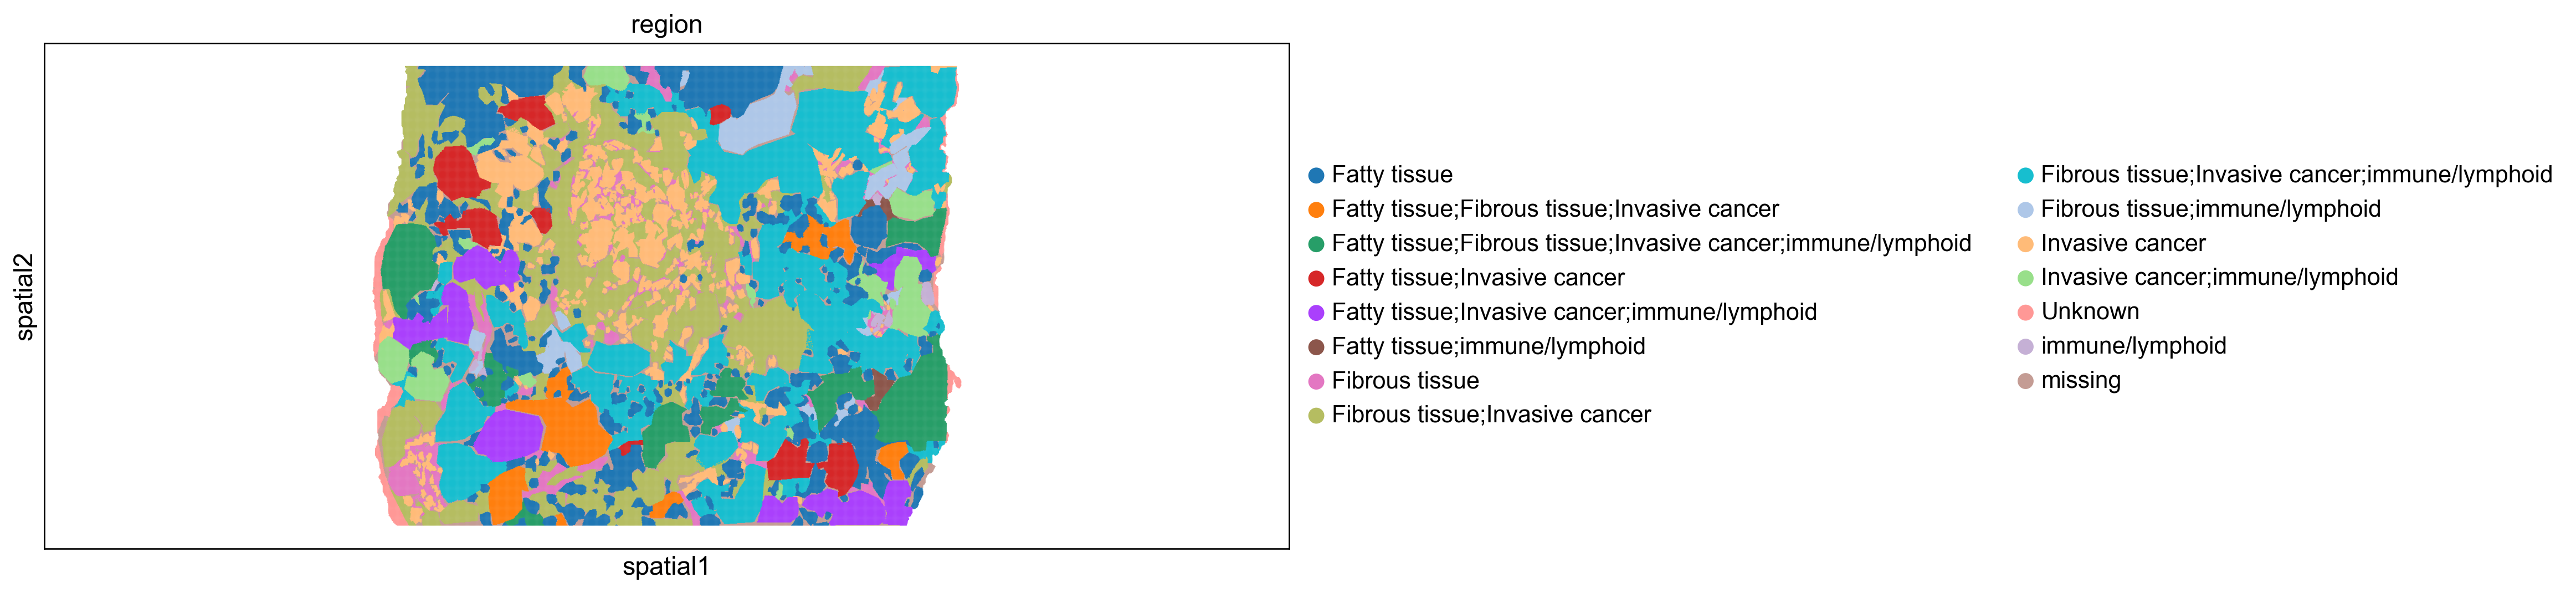

In [24]:
f, ax = plt.subplots(figsize=(12, 5))
sc.pl.scatter(adata, basis='spatial', color='region', size=1., ax=ax, show=False)
ax.axis('equal');

... storing 'region' as categorical
... storing 'segment' as categorical


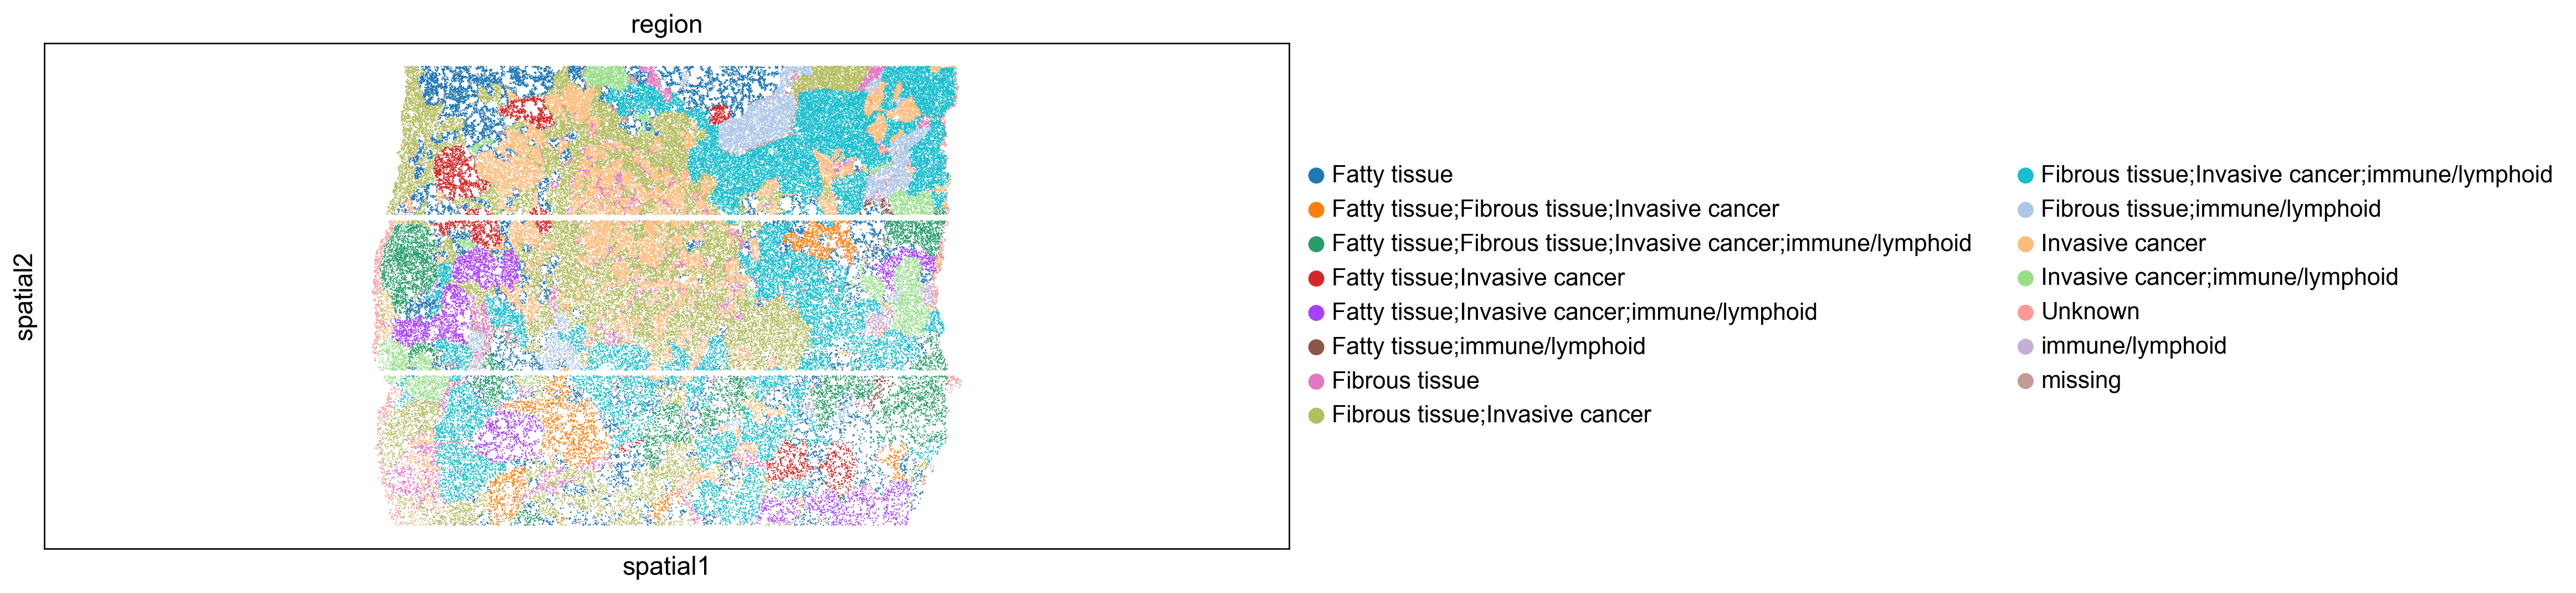

In [25]:
f, ax = plt.subplots(figsize=(12, 5))
sc.pl.scatter(adata[adata.obs.segment != '0'], basis='spatial', color='region', size=2., ax=ax, show=False)
ax.axis('equal');

In [26]:
adata

AnnData object with n_obs × n_vars = 742440 × 23058 
    obs: 'region', 'segment'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial'

In [27]:
adata.obs.head(20)

region segment
1000x0    Fibrous tissue;Invasive cancer       0
1000x1    Fibrous tissue;Invasive cancer       0
1000x10   Fibrous tissue;Invasive cancer       0
1000x100  Fibrous tissue;Invasive cancer       0
1000x101  Fibrous tissue;Invasive cancer       0
1000x102  Fibrous tissue;Invasive cancer       0
1000x103  Fibrous tissue;Invasive cancer       0
1000x104  Fibrous tissue;Invasive cancer       0
1000x105  Fibrous tissue;Invasive cancer       0
1000x106  Fibrous tissue;Invasive cancer       0
1000x107  Fibrous tissue;Invasive cancer       0
1000x108  Fibrous tissue;Invasive cancer       0
1000x109  Fibrous tissue;Invasive cancer       0
1000x11   Fibrous tissue;Invasive cancer       0
1000x110  Fibrous tissue;Invasive cancer       0
1000x111  Fibrous tissue;Invasive cancer       0
1000x112  Fibrous tissue;Invasive cancer       0
1000x113  Fibrous tissue;Invasive cancer       0
1000x114  Fibrous tissue;Invasive cancer       0
1000x115  Fibrous tissue;Invasive cancer       0

In [28]:
sc.pp.filter_cells(adata, min_counts=1, copy=True)

AnnData object with n_obs × n_vars = 177926 × 23058 
    obs: 'region', 'segment', 'n_counts'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial'

In [29]:
sc.write('results/hdst-breast-cancer.h5ad', adata)

... storing 'region' as categorical
... storing 'segment' as categorical
